In [50]:
import datetime

import pandas as pd
import pyarrow as pa
import numpy as np
from utils import load_saved_data, get_connection, get_data
from statsforecast import StatsForecast
from statsforecast.models import AutoARIMA, MSTL
#obtain hierarchical reconciliation methods and evaluation
from hierarchicalforecast.core import HierarchicalReconciliation
from hierarchicalforecast.evaluation import HierarchicalEvaluation
from hierarchicalforecast.methods import BottomUp, TopDown, MiddleOut, MinTrace, ERM, Normality
from hierarchicalforecast.utils import aggregate

In [51]:
# df = load_saved_data()
# conn = get_connection()
# df = get_data(conn, 2018, 2018, 2_000_000, 0)
df = pd.read_feather("../data/2018.feather")



In [52]:
df.describe()

,created_date,closed_date,resolution_action_updated_date,latitude,longitude,due_date
count,2000000,1965900,1983912,1.854231e+06,1.854231e+06,913148
mean,2018-08-22 09:45:50.460096512,2018-09-09 20:51:52.718702336,2018-09-09 12:56:10.453158144,4.072587e+01,-7.392462e+01,2018-09-02 06:03:26.296805376
min,2018-04-13 18:06:41,2007-12-04 00:00:00,2013-05-17 00:00:00,4.049895e+01,-7.425495e+01,2018-04-13 19:07:03
25%,2018-06-19 00:18:42.750000128,2018-06-26 11:17:00,2018-06-26 16:39:59.249999872,4.066430e+01,-7.397041e+01,2018-06-24 05:16:26.249999872
50%,2018-08-22 15:04:00,2018-09-02 08:50:00,2018-09-03 08:47:33,4.071663e+01,-7.392741e+01,2018-08-27 10:05:32
75%,2018-10-24 22:29:17.250000128,2018-11-06 15:55:19.500000,2018-11-07 10:52:22,4.079664e+01,-7.387562e+01,2018-10-30 09:39:18.249999872
max,2019-01-31 14:56:00,2209-01-02 00:00:00,2024-02-12 11:40:59,4.091294e+01,-7.370038e+01,2022-07-21 02:22:26
std,NaN,NaN,NaN,8.583186e-02,8.448541e-02,NaN


In [53]:
df[["latitude","borough"]].describe(include='all')

,latitude,borough
count,1854231.0,1999173
unique,<NA>,6
top,<NA>,BROOKLYN
freq,<NA>,635678
mean,40.725866,NaN
std,0.085832,NaN
min,40.498949,NaN
25%,40.664304,NaN
50%,40.716628,NaN
75%,40.796643,NaN


In [54]:
df[df["latitude"].isnull()]["borough"].unique()


<ArrowStringArray>
[       'QUEENS',      'BROOKLYN',         'BRONX',     'MANHATTAN',
   'Unspecified', 'STATEN ISLAND',            <NA>]
Length: 7, dtype: string

In [55]:
df[(df["borough"]=="Unspecified") &  (df["latitude"].notnull())].count()

created_date                      2287
closed_date                       2285
agency                            2287
complaint_type                    2287
status                            2287
resolution_action_updated_date    2284
borough                           2287
descriptor                        2272
resolution_description            2272
incident_zip                      2144
city                              2251
latitude                          2287
longitude                         2287
due_date                          1814
bbl                                 40
dtype: int64

In [56]:
df[(df["borough"]=="Unspecified") &  (df["latitude"].isnull()) & (df["incident_zip"].isnull())].count()


created_date                      22943
closed_date                       20878
agency                            22943
complaint_type                    22943
status                            22943
resolution_action_updated_date    12127
borough                           22943
descriptor                        22929
resolution_description            22910
incident_zip                          0
city                                  1
latitude                              0
longitude                             0
due_date                          12806
bbl                                   0
dtype: int64

In [57]:
df = df[df["closed_date"]>df["created_date"]]

In [58]:
df["hours_to_complete"] =  pd.to_datetime(df["closed_date"]) - pd.to_datetime(df["created_date"])

In [59]:
# time_to_complete = pd.to_datetime(df["hours_to_complete"])
df['hours_to_complete'] = df["hours_to_complete"].astype("float64")/(3.6e12)
# df= df.drop("hours_to_update", axis=1)
# df = df.drop(df[df["hours_to_complete"]<0].index, axis=0)

In [60]:
df['hours_to_complete']

121           1.424444
122           1.414722
123          98.101111
124        1064.892778
125         122.111667
              ...     
1999995       4.133333
1999996       1.621667
1999997       2.299167
1999998     567.830833
1999999     567.830833
Name: hours_to_complete, Length: 1886370, dtype: float64

<Axes: title={'center': 'Number of Unclosed Requests by Agency'}, xlabel='Agency', ylabel='Unclosed Request Count'>

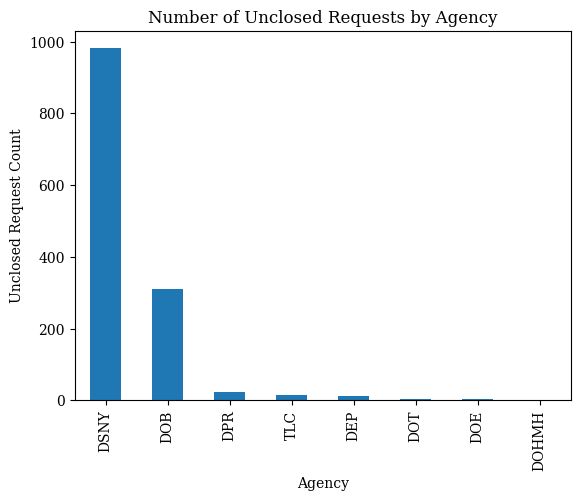

In [61]:
unclosed = df[df["status"]!="Closed"]["agency"].value_counts()
unclosed.plot.bar(title="Number of Unclosed Requests by Agency", xlabel="Agency", ylabel="Unclosed Request Count")

In [62]:
# cl_hr_1 = df["closed_date"].groupby([df["closed_date"].dt.date, df["closed_date"].dt.hour]).value_counts().cumsum()
# conver to hours
# create cumulative sum by summing value count by date for closed date and created date
# subtract the series of cumsums from each other to get number of open per hour

In [63]:
    # temp_created = df['created_date'].groupby(level=list(range(df.index.nlevels))) \
    #                 .apply(lambda x: pd.Series(1, index=pd.to_datetime(x.astype("int64"))) \
    #                 .resample('H', origin="start_day").sum().cumsum()
    #                 # .reset_index("borough", drop=True)
    #                 )



    # cr_hr_1 = df["created_date"].groupby(grp_by_create).count().cumsum()
    # cr_hr_1.index.set_names(col_names, inplace=True)

    # grp_by_closed = [df["closed_date"].dt.date, df["closed_date"].dt.hour]
    # grp_by_closed.extend(grp_adds)

    # cl_hr_1 = df["closed_date"].groupby(grp_by_closed).count().cumsum()
    # cl_hr_1.index.set_names(col_names, inplace=True)


In [66]:
def add_open_count_feat(df:pd.DataFrame, features:list[str]):
    # col_names = ["datetime",] + features
    # col name for new feature
    trunc_name = "_".join(["open"]+[name[:2] for name in features])

    # df.sort_values("closed_date",ascending=True,axis=0,ignore_index=True,inplace=True)
    # set the index to features and date closed
    df.set_index(features, inplace=True)
    df.set_index(pd.to_datetime(df["closed_date"].astype("int64")).dt.floor("H"), inplace=True, append=True)
    # sort by closed date
    df.sort_index(axis=0, level="closed_date", ascending=True, inplace=True)

    # count number closed per hour
    t_num_closed = df['closed_date'].groupby(level=list(range(df.index.nlevels))).count().cumsum()
    # remove closed date from index
    df.reset_index("closed_date", drop=True, inplace=True)

    # Add created date to index
    df.set_index(pd.to_datetime(df["created_date"].astype("int64")).dt.floor("H"), inplace=True, append=True)
    df.sort_index(axis=0, level="created_date", ascending=True, inplace=True)
    t_num_created = df['created_date'].groupby(level=list(range(df.index.nlevels))).count().cumsum()


    t_num_created = t_num_created.reindex(t_num_closed.index, method='ffill')
    t_num_closed = t_num_closed.reindex(t_num_created.index, method='ffill')
    # t_num_created.index.set_names("datetime",level= "created_date")
    # t_num_created.index.loc["datetime"].asfreq("H")
    # t_num_closed.index.set_names("datetime",level= "closed_date")
    # t_num_closed.index.loc["datetime"].asfreq("H")

    diff = t_num_created - t_num_closed
    diff = diff.reindex(df.index)
    diff.groupby(level=0).plot()
    # df = df.set_index([df["created_date"].dt.date, df["created_date"].dt.hour]+features)
    # df[trunc_name] = t_num_closed-t_num_created

    df[trunc_name] = diff

    df.reset_index(features, inplace=True)
    df.reset_index(drop=True,inplace=True)
    return t_num_closed, t_num_created

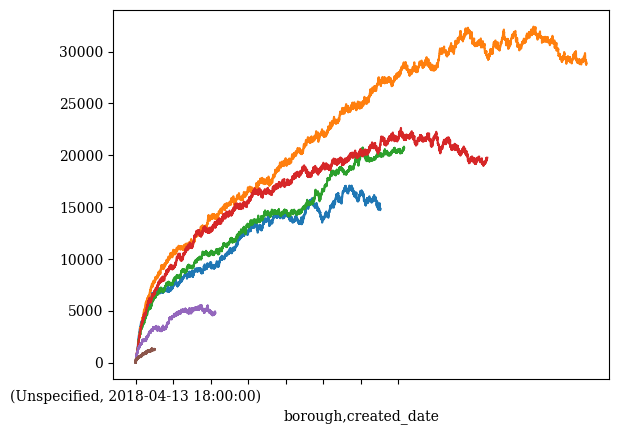

In [67]:
try:
    closed, created = add_open_count_feat(df, ["borough"])
except Exception as e:
    display(df)
    df.reset_index("borough", inplace=True)
    df.reset_index(drop=True,inplace=True)
    raise e
# df

borough
BRONX            Axes(0.125,0.11;0.775x0.77)
BROOKLYN         Axes(0.125,0.11;0.775x0.77)
MANHATTAN        Axes(0.125,0.11;0.775x0.77)
QUEENS           Axes(0.125,0.11;0.775x0.77)
STATEN ISLAND    Axes(0.125,0.11;0.775x0.77)
Unspecified      Axes(0.125,0.11;0.775x0.77)
dtype: object

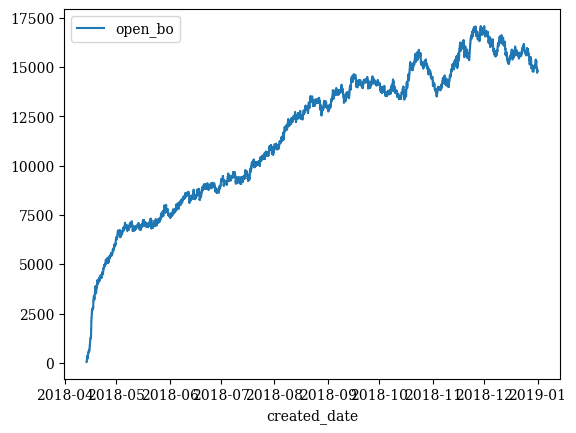

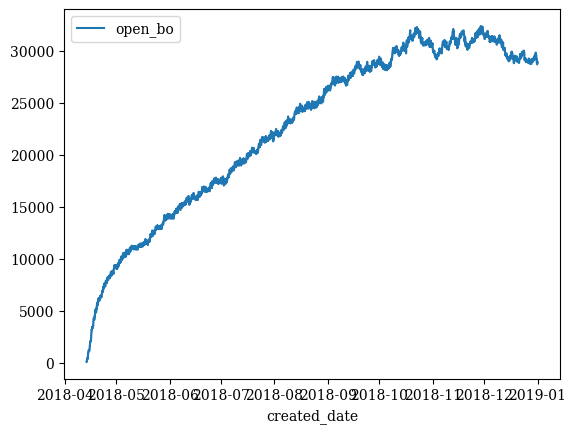

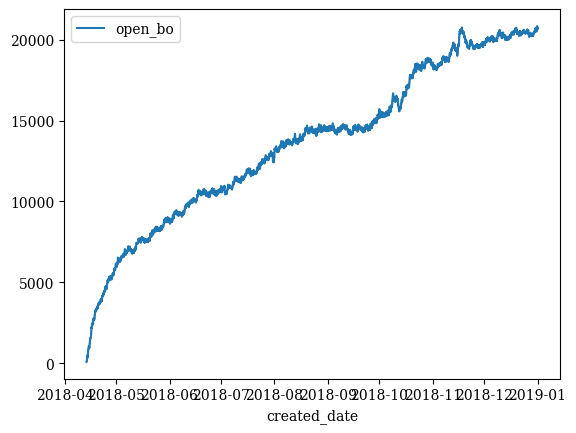

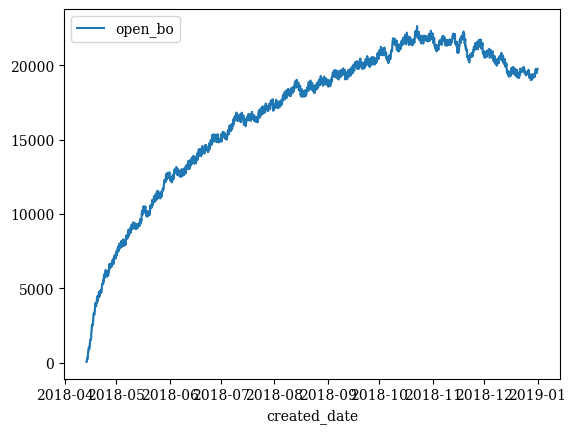

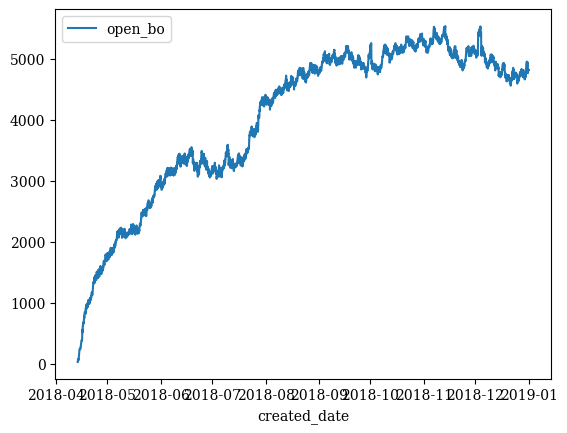

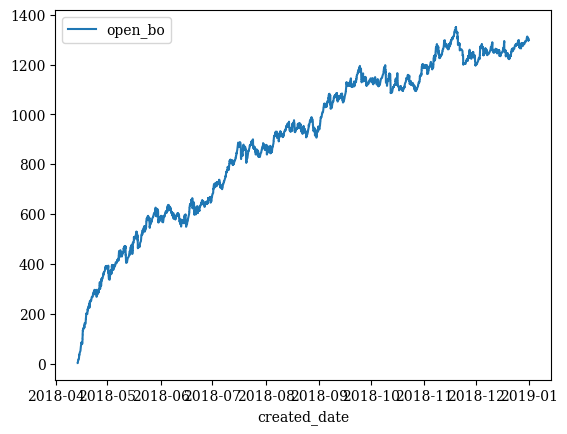

In [68]:
df[df["open_bo"]>0].groupby("borough").plot(x="created_date", y="open_bo")

In [ ]:
df = df.dropna(axis=0)


In [ ]:
# df.columns = ['borough', 'agency', 'created_date', 'closed_date', 'complaint_type',
#        'status', 'resolution_action_updated_date', 'descriptor',
#        'resolution_description', 'incident_zip', 'city', 'latitude',
#        'longitude', 'due_date', 'bbl', 'hours_to_complete', 'open',
#        'open_ag_br', 'open_ag', 'open_br']
df.columns = [
       'borough', 'agency',
       'ds', 'closed_date',
       'complaint_type', 'status',
       'resolution_action_updated_date', 'descriptor',
       'resolution_description', 'incident_zip',
       'city', 'latitude',
       'longitude', 'due_date',
       'bbl', 'hours_to_complete',
       'open', 'y',
       'open_ag', 'open_br'
]


In [ ]:
# heirarchies = [
#     ["borough"],
#     [ "borough","incident_zip"],
#     [ "borough","incident_zip", "agency"],
#     [ "borough","incident_zip", "agency", "complaint_type"],
# ]
hdf = df[df["borough"]!= "Unspecified"]
bdf, H_df, tags = aggregate(
    hdf,
    spec=[["agency","borough"]]
)

In [ ]:
bdf

In [ ]:
hrec = HierarchicalReconciliation(
    reconcilers =
        [
            MinTrace("ols", nonnegative=True,num_threads=-1),
            # ERM("closed"),
            # BottomUp()
        ]
)


In [ ]:


Y_df = bdf[(bdf['ds']>datetime.date(year=2018, month=10, day=1)) & (bdf['ds']<datetime.date(year=2018, month=12, day=1))]
Y_df

In [ ]:

models = [MSTL(
    season_length=[24, 24 * 7], # seasonalities of the time series
    trend_forecaster=AutoARIMA(trace=True) # model used to forecast trend
)]
sf = StatsForecast(
    models = models,
    freq = 'H',
    df=Y_df,
    n_jobs=-1
    )
sf.fit()

In [ ]:
fcts  = sf.forecast(h=1,df=bdf, level=[90])

In [ ]:
fcts

In [ ]:
StatsForecast.plot(df=Y_df, forecasts_df=fcts[fcts.index.isin(bdf.index)].fillna(0))